In [1]:
cd ../src

/home/richard/Desktop/software/epicluster-results_upload/epicluster-results/src


In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import copy
import scipy.stats
import branchpro
import epicluster as ec

In [3]:
random.seed(123)
np.random.seed(123)

In [4]:
all_results = []
for endpt in [225, 230, 235, 240, 245, 250, 255, 260]:

    # serial interval
    w = scipy.stats.gamma(2.707, scale=1/0.177)
    w = w.pdf(np.arange(50))
    w = w / sum(w)


    # data
    data = pd.read_csv("../data/synthetic/synthetic2_resurgence.csv")
    Rt_series = np.asarray(data['Rt'])
    cases = np.asarray(data['cases'])[:endpt]

    past_cases = np.ones(len(w)) * 5
    inf_cases = np.concatenate([past_cases, cases])


    # run branchpro
    a = 1
    b = 5

    inc_data = pd.DataFrame(
        {
            'Time': np.arange(len(inf_cases)),
            'Incidence Number': inf_cases
        }
    )

    inference = branchpro.BranchProPosterior(
        inc_data=inc_data,
        daily_serial_interval=w,
        alpha=a,
        beta=1/b)

    inference.run_inference(tau=7)
    intervals7 = inference.get_intervals(central_prob=.9)

    inference.run_inference(tau=28)
    intervals28 = inference.get_intervals(central_prob=.9)


    # run change point
    p = ec.PoissonModel(copy.deepcopy(inf_cases), w, prior_expected_clusters=1.5)
    mcmc = ec.MCMCSampler(p, 2)
    phi_chain, z_chain, counts = mcmc.run_mcmc(Rhat_thresh=1.05, progress=True)



    # load epifilter
    epi_results = pd.read_csv('../data/synthetic/results/online/synthetic_2_R_{}.csv'.format(endpt))


    # save results
    results_synth = cases, Rt_series, w, phi_chain, z_chain, intervals7, intervals28, epi_results
    
    all_results.append(results_synth)

Iter=50, Rhat=63.439761760025185
Iter=100, Rhat=39.62710081445662
Iter=150, Rhat=22.353806426043878
Iter=200, Rhat=21.86421938119954
Iter=250, Rhat=13.241726501406513
Iter=300, Rhat=11.22155664909007
Iter=350, Rhat=7.765906357370568
Iter=400, Rhat=5.29898218580952
Iter=450, Rhat=3.9039107179340955
Iter=500, Rhat=3.51872563738837
Iter=550, Rhat=3.0673511787802217
Iter=600, Rhat=2.3090790996246717
Iter=650, Rhat=1.7577381752263264
Iter=700, Rhat=1.4442400984683013
Iter=750, Rhat=1.2858732039357015
Iter=800, Rhat=1.1958746589873388
Iter=850, Rhat=1.1186103922755646
Iter=900, Rhat=1.055085708369795
Iter=950, Rhat=1.027375282323488
Converged 950 1.027375282323488
Iter=50, Rhat=75.05145326481696
Iter=100, Rhat=37.30827740134909
Iter=150, Rhat=22.646180401553146
Iter=200, Rhat=17.17458317373568
Iter=250, Rhat=14.114787964160543
Iter=300, Rhat=9.970710272794104
Iter=350, Rhat=7.22649887170127
Iter=400, Rhat=5.632904972420296
Iter=450, Rhat=3.877161785086592
Iter=500, Rhat=3.447747685601715
Ite

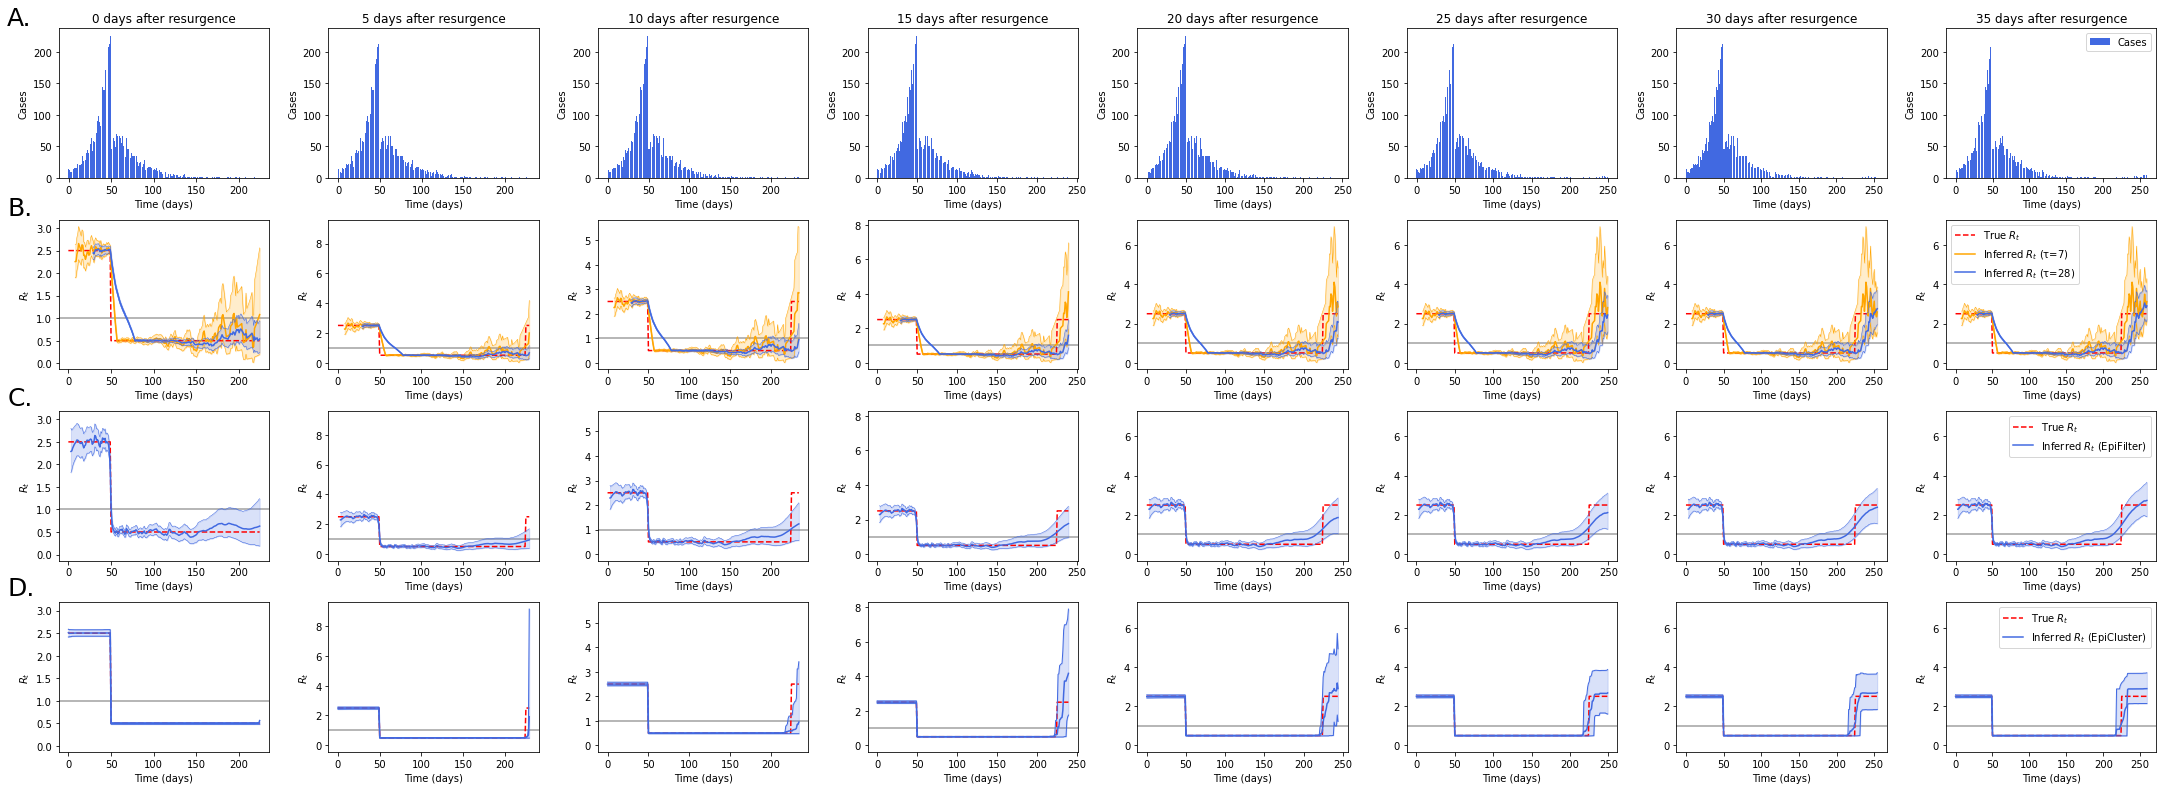

In [5]:
fig = plt.figure(figsize=(30,11))

num_exps = 8

for i in range(num_exps):
    
    do_legend = i==num_exps-1
    
    cases, Rt_series, w, phi_chain, z_chain, intervals7, intervals28, epi_results = all_results[i]
        
    ax = fig.add_subplot(4, num_exps, 1+i)

    x = np.arange(len(cases))
    ax.bar(x, cases, label='Cases', color='royalblue')
    ax.set_title('{} days after resurgence'.format(i*5))

    if do_legend:
        ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Cases')

    ax = fig.add_subplot(4, num_exps, 3*num_exps+i+1)
    Rs = []
    num_mcmc = len(z_chain)
    for phi, z in zip(phi_chain[num_mcmc//4:], z_chain[num_mcmc//4:]):
        Rs.append([phi[zi] for zi in z])
    ax.plot(x, Rt_series[:len(x)], color='red', label='True $R_t$', ls='--')
    ax.plot(x, np.mean(Rs, axis=0), color='royalblue', label='Inferred $R_t$ (EpiCluster)')
    ax.fill_between(x, np.percentile(Rs, 5, axis=0), np.percentile(Rs, 95, axis=0), color='royalblue', alpha=0.2)
    ax.plot(x, np.percentile(Rs, 5, axis=0), color='royalblue', lw=1)
    ax.plot(x, np.percentile(Rs, 95, axis=0), color='royalblue', lw=1)
    
    ax.axhline(1, color='gray', alpha=0.75, zorder=-10)
    if do_legend:
        ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$R_t$')

    ax = fig.add_subplot(4, num_exps, num_exps+i+1, sharey=ax)
    x = np.arange(len(w), len(cases))
    x = np.arange(len(cases))
    ax.plot(x, Rt_series[:len(x)], color='red', label='True $R_t$', ls='--')

    x = np.arange(8, len(cases))
    ax.plot(x, intervals7['Mean'][len(w):], color='orange', label='Inferred $R_t$ (τ=7)')
    ax.fill_between(x, intervals7['Lower bound CI'][len(w):], intervals7['Upper bound CI'][len(w):], alpha=0.2, color='orange')
    ax.plot(x, intervals7['Lower bound CI'][len(w):], color='orange', lw=0.5)
    ax.plot(x, intervals7['Upper bound CI'][len(w):], color='orange', lw=0.5)
    
    x = np.arange(29, len(cases))
    ax.plot(x, intervals28['Mean'][len(w):], color='royalblue', label='Inferred $R_t$ (τ=28)')
    ax.fill_between(x, intervals28['Lower bound CI'][len(w):], intervals28['Upper bound CI'][len(w):], alpha=0.2, color='royalblue')
    ax.plot(x, intervals28['Lower bound CI'][len(w):], color='royalblue', lw=0.5)
    ax.plot(x, intervals28['Upper bound CI'][len(w):], color='royalblue', lw=0.5)

    ax.axhline(1, color='gray', alpha=0.75, zorder=-10)
    if do_legend:
        ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$R_t$')
    
    
    
    ax = fig.add_subplot(4, num_exps, 2*num_exps+i+1, sharey=ax)
    
    x = np.arange(len(w), len(cases))
    x = np.arange(len(cases))
    ax.plot(x, Rt_series[:len(x)], color='red', label='True $R_t$', ls='--')


    x = epi_results['day'][1:len(x)+1]
    mean = epi_results['R_smooth'][1:len(x)+1]
    lb = epi_results['R_smooth_lower_bound'][1:len(x)+1]
    ub = epi_results['R_smooth_upper_bound'][1:len(x)+1]
    ax.plot(x, mean, color='royalblue', label='Inferred $R_t$ (EpiFilter)')
    ax.fill_between(x, lb, ub, alpha=0.2, color='royalblue')
    ax.plot(x, lb, color='royalblue', lw=0.5)
    ax.plot(x, ub, color='royalblue', lw=0.5)  

    ax.axhline(1, color='gray', alpha=0.75, zorder=-10)
    if do_legend:
        ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$R_t$')
    

fig.set_tight_layout(True)

plt.subplots_adjust(left=0.2)
fig.text(.0, .97, 'A.', fontsize=25)
fig.text(.0, .73, 'B.', fontsize=25)
fig.text(.0, .49, 'C.', fontsize=25)
fig.text(.0, .25, 'D.', fontsize=25)

plt.savefig('../notebooks/FigureS4.pdf')
plt.show()


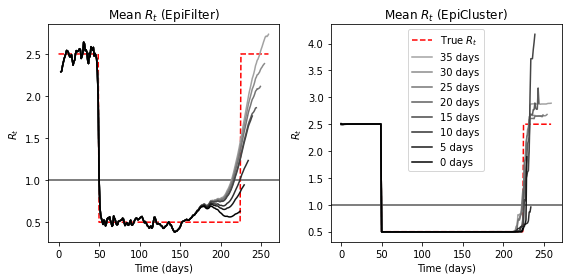

In [6]:
fig = plt.figure(figsize=(8, 4))

num_exps = 8

ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2)


import matplotlib
cmap = matplotlib.cm.get_cmap('binary_r')

for i in range(num_exps)[::-1]:
    
    do_legend = True
    
    cases, Rt_series, w, phi_chain, z_chain, intervals7, intervals28, epi_results = all_results[i]
        
    x = np.arange(len(cases))

    ax = ax3
    ax.set_title('Mean $R_t$ (EpiCluster)')
    Rs = []
    for phi, z in zip(phi_chain[num_mcmc//4:], z_chain[num_mcmc//4:]):
        Rs.append([phi[zi] for zi in z])
    if i == 7:
        ax.plot(x, Rt_series[:len(x)], color='red', label='True $R_t$', ls='--')
    ax.plot(x, np.mean(Rs, axis=0), color=cmap(i/11), label='{} days'.format(i*5))

    ax.axhline(1, color='gray', alpha=0.75, zorder=-10)
    if do_legend:
        ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$R_t$')

    
    ax = ax2
    ax.set_title('Mean $R_t$ (EpiFilter)')
    
    x = np.arange(len(w), len(cases))
    x = np.arange(len(cases))
    if i == 7:
        ax.plot(x, Rt_series[:len(x)], color='red', label='True $R_t$', ls='--')


    x = epi_results['day'][1:len(x)+1]
    mean = epi_results['R_smooth'][1:len(x)+1]
    ax.plot(x, mean, color=cmap(i/11))

    ax.axhline(1, color='gray', alpha=0.75, zorder=-10)

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$R_t$')
    

fig.set_tight_layout(True)



plt.savefig('../notebooks/Figure4.pdf')
plt.show()
